In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/short-dark-triad/SD3/codebook.txt
/kaggle/input/short-dark-triad/SD3/data.csv


In [2]:
!pip install pygad scikit-fuzzy torchviz joblib ga --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 19.3 MB/s eta 0:00:0000:01


In [3]:
data=pd.read_csv("/kaggle/input/short-dark-triad/SD3/data.csv",sep='\t')
data.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9,N1,...,P2,P3,P4,P5,P6,P7,P8,P9,country,source
0,4,4,4,4,4,4,4,3,4,2,...,4,3,2,4,4,4,4,4,GB,1
1,2,1,5,2,2,1,2,2,3,1,...,1,1,5,4,1,5,3,2,US,1
2,3,3,3,5,1,1,5,5,3,2,...,5,3,1,3,1,2,3,1,US,1
3,5,5,4,5,5,5,5,5,5,5,...,1,5,2,5,5,5,1,5,GB,3
4,4,4,2,5,5,5,4,1,4,3,...,5,3,1,4,3,5,4,1,GB,3


In [4]:
question_cols = data.columns[:-2]
tech_cols = ['source', 'country']  # technical information
data[question_cols] = data[question_cols].apply(pd.to_numeric, errors='coerce')
X = data[question_cols].values

In [5]:
question_cols

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9'],
      dtype='object')

In [6]:
X

array([[4, 4, 4, ..., 4, 4, 4],
       [2, 1, 5, ..., 5, 3, 2],
       [3, 3, 3, ..., 2, 3, 1],
       ...,
       [4, 3, 3, ..., 2, 4, 1],
       [5, 4, 3, ..., 4, 1, 3],
       [4, 4, 4, ..., 3, 4, 4]])

In [7]:
import joblib
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Normalize responses: scale from 1-5 to [0,1]
X_norm = (X - 1) / 4.0
print("Normalized data shape:", X_norm.shape)
# Fit PCA to the normalized data (use same n_components as during training)
pca = PCA(n_components=9)
X_reduced = pca.fit_transform(X_norm)

# Save the PCA transformer to a .pkl file
joblib.dump(pca, "pca_transform.pkl")
print("Reduced data shape:", X_reduced.shape)
print("PCA transformer saved to pca_transform.pkl")

Normalized data shape: (18192, 27)
Reduced data shape: (18192, 9)
PCA transformer saved to pca_transform.pkl


Pseudo-label distribution: [4921 5658 7613]
ANFIS(
  (fuzzy): FuzzyLayer()
  (rule): RuleLayer()
  (consequent): ConsequentLayer()
)
Epoch 1/30 - Train Loss: 1.0061 - Val Loss: 0.8421
Epoch 2/30 - Train Loss: 0.7578 - Val Loss: 0.6995
Epoch 3/30 - Train Loss: 0.6702 - Val Loss: 0.6362
Epoch 4/30 - Train Loss: 0.6265 - Val Loss: 0.6033
Epoch 5/30 - Train Loss: 0.5925 - Val Loss: 0.5690
Epoch 6/30 - Train Loss: 0.5276 - Val Loss: 0.4586
Epoch 7/30 - Train Loss: 0.4093 - Val Loss: 0.3616
Epoch 8/30 - Train Loss: 0.3334 - Val Loss: 0.3012
Epoch 9/30 - Train Loss: 0.2787 - Val Loss: 0.2483
Epoch 10/30 - Train Loss: 0.2309 - Val Loss: 0.2008
Epoch 11/30 - Train Loss: 0.1882 - Val Loss: 0.1724
Epoch 12/30 - Train Loss: 0.1666 - Val Loss: 0.1569
Epoch 13/30 - Train Loss: 0.1553 - Val Loss: 0.1487
Epoch 14/30 - Train Loss: 0.1482 - Val Loss: 0.1397
Epoch 15/30 - Train Loss: 0.1431 - Val Loss: 0.1348
Epoch 16/30 - Train Loss: 0.1373 - Val Loss: 0.1323
Epoch 17/30 - Train Loss: 0.1336 - Val Loss:

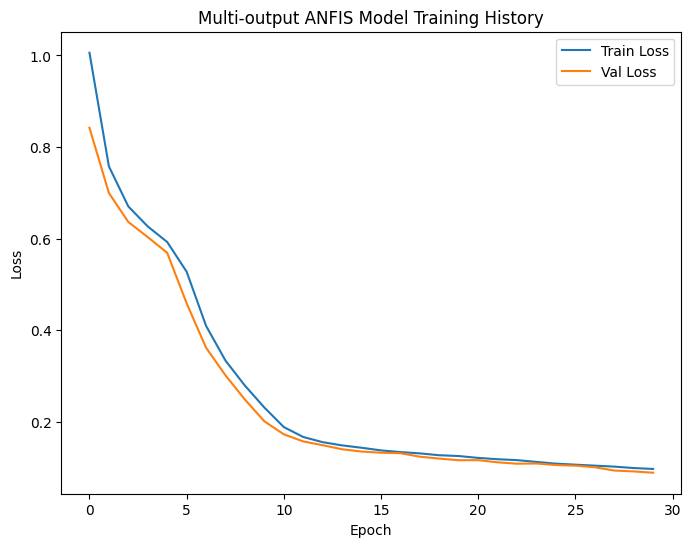

In [11]:
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# =============================================================================
# Robust Clustering: Compare KMeans and Agglomerative Clustering
# =============================================================================
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pseudo_labels = kmeans.fit_predict(X_reduced)
print("Pseudo-label distribution:", np.bincount(pseudo_labels))
# For classification with CrossEntropyLoss, targets must be 1D long tensors.
y_tensor = torch.tensor(pseudo_labels, dtype=torch.long)

# Convert PCA-reduced data to torch tensor.
X_reduced_tensor = torch.tensor(X_reduced, dtype=torch.float32)

# =============================================================================
# Define Custom ANFIS Modules in PyTorch (Multi-output version)
# =============================================================================
class FuzzyLayer(nn.Module):
    def __init__(self, input_dim, num_mfs=2):
        super(FuzzyLayer, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs
        # Trainable parameters for each input: centers and sigmas.
        self.centers = nn.Parameter(torch.rand(input_dim, num_mfs))
        self.sigmas = nn.Parameter(torch.rand(input_dim, num_mfs))
    
    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x_expanded = x.unsqueeze(2)  # (batch, input_dim, 1)
        membership = torch.exp(- (x_expanded - self.centers)**2 / (2 * self.sigmas**2 + 1e-6))
        return membership  # (batch, input_dim, num_mfs)

class RuleLayer(nn.Module):
    def __init__(self):
        super(RuleLayer, self).__init__()
    
    def forward(self, x):
        batch_size = x.shape[0]
        flat = x.view(batch_size, -1)
        return flat

class ConsequentLayer(nn.Module):
    def __init__(self, num_rules, output_dim=3):  # output_dim=3 for three traits
        super(ConsequentLayer, self).__init__()
        self.num_rules = num_rules
        self.output_dim = output_dim
        # Consequent parameters: one weight per rule for each output.
        self.consequents = nn.Parameter(torch.rand(num_rules, output_dim))
    
    def forward(self, x):
        # x shape: (batch_size, num_rules)
        norm_firing = x / (torch.sum(x, dim=1, keepdim=True) + 1e-6)
        output = torch.matmul(norm_firing, self.consequents)
        return output

class ANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs=2, output_dim=3):
        super(ANFIS, self).__init__()
        self.fuzzy = FuzzyLayer(input_dim, num_mfs)
        self.rule = RuleLayer()
        # Total number of rules = input_dim * num_mfs (simplified approach)
        self.num_rules = input_dim * num_mfs
        self.consequent = ConsequentLayer(self.num_rules, output_dim)
    
    def forward(self, x):
        fuzzy_out = self.fuzzy(x)       # (batch, input_dim, num_mfs)
        rule_out = self.rule(fuzzy_out)   # (batch, input_dim * num_mfs)
        output = self.consequent(rule_out) # (batch, output_dim)
        return output

# =============================================================================
# Build and Train the ANFIS Model using Gradient Descent
# =============================================================================
input_dim = X_reduced.shape[1]  # PCA components (9)
num_mfs = 2
output_dim = 3  # Three outputs corresponding to M, N, P
model = ANFIS(input_dim=input_dim, num_mfs=num_mfs, output_dim=output_dim)
print(model)

# Use CrossEntropyLoss: This loss combines LogSoftmax and NLLLoss.
# It expects outputs of shape (N, C) and targets of shape (N,) with integer labels.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
batch_size = 16
dataset_size = X_reduced_tensor.shape[0]

# Create training and validation splits (80/20 split)
indices = np.arange(dataset_size)
np.random.shuffle(indices)
split = int(0.8 * dataset_size)
train_idx, val_idx = indices[:split], indices[split:]
X_train = X_reduced_tensor[train_idx]
y_train = y_tensor[train_idx]
X_val = X_reduced_tensor[val_idx]
y_val = y_tensor[val_idx]

loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0.0
    for i in range(0, X_train.size()[0], batch_size):
        optimizer.zero_grad()
        indices_batch = permutation[i:i+batch_size]
        batch_x = X_train[indices_batch]
        batch_y = y_train[indices_batch]  # targets: shape (batch,) with values 0,1,2
        outputs = model(batch_x)  # outputs: shape (batch, 3)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= X_train.size()[0]
    loss_history.append(epoch_loss)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
        val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

# =============================================================================
# Evaluation
# =============================================================================
model.eval()
with torch.no_grad():
    outputs = model(X_reduced_tensor)
    # Get predictions: choose the class with maximum logit
    _, y_pred = torch.max(outputs, dim=1)
    y_pred = y_pred.cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    
accuracy = accuracy_score(y_true, y_pred)
print("Final ANFIS Model Classification Accuracy:", accuracy)

# =============================================================================
# Save the trained model weights in .pth format
# =============================================================================
torch.save(model.state_dict(), "final_model_weights.pth")
print("Model weights saved to final_model_weights.pth")

# =============================================================================
# Plot Training History
# =============================================================================
plt.figure(figsize=(8,6))
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Multi-output ANFIS Model Training History")
plt.legend()
plt.show()

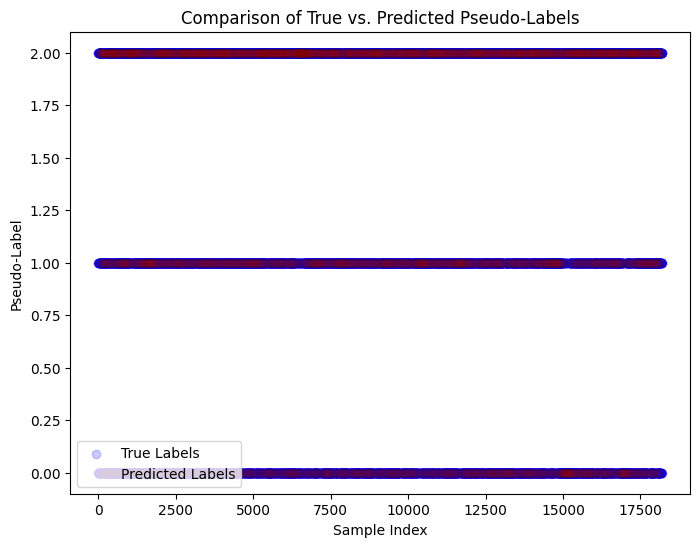

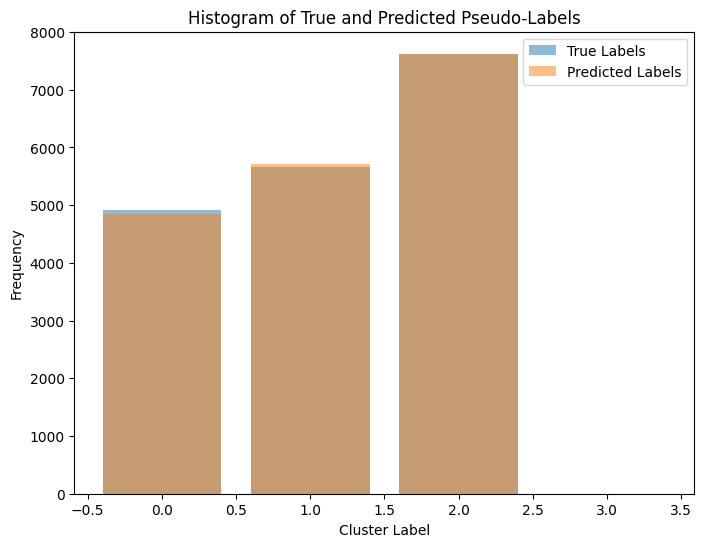

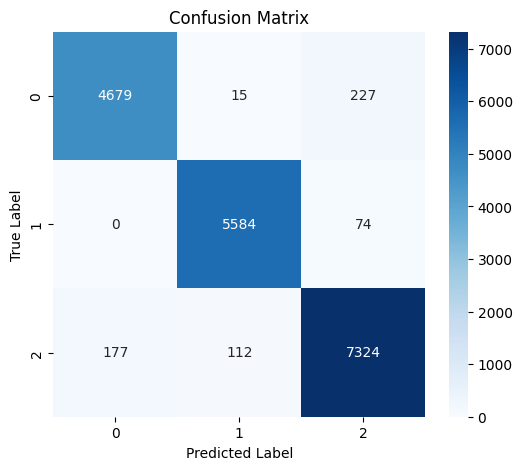

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# After running your model evaluation, suppose you have:
# y_true_labels: true pseudo-labels as integers
# y_pred_labels: model predictions (rounded to nearest integer)

# Scatter plot: Predicted vs. True Pseudo-Labels
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_true)), y_true, color='blue', label='True Labels', alpha=0.2)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Labels', alpha=0.008)
plt.xlabel("Sample Index")
plt.ylabel("Pseudo-Label")
plt.title("Comparison of True vs. Predicted Pseudo-Labels")
plt.legend()
plt.show()

# Histogram of Predictions vs. True Labels
plt.figure(figsize=(8,6))
plt.hist(y_true, bins=np.arange(-0.5, 4, 1), alpha=0.5, label='True Labels', rwidth=0.8)
plt.hist(y_pred, bins=np.arange(-0.5, 4, 1), alpha=0.5, label='Predicted Labels', rwidth=0.8)
plt.xlabel("Cluster Label")
plt.ylabel("Frequency")
plt.title("Histogram of True and Predicted Pseudo-Labels")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Visualize the model architecture using torchviz
import torch
from torchviz import make_dot

# Create a dummy input tensor with the same number of features as the PCA-reduced data.
dummy_input = torch.randn(1, X_reduced.shape[1])  # shape: (1, input_dim)
model_output = model(dummy_input)

# Generate a graph of the model.
dot = make_dot(model_output, params=dict(list(model.named_parameters())))
dot.render("ANFIS_model_architecture", format="png")  # This will save 'ANFIS_model_architecture.png'


'ANFIS_model_architecture.png'